## Adaptive warmstarting of Hyperparameters
In this notebook, we implement some adaptive warmstarting for the hyperparameters to avoid the search getting stuck in local regions.

In [7]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from openml import datasets, tasks, flows, config

from openmlstudy14.preprocessing import ConditionalImputer
from workloadoptimization.essentials import Component, ExperimentParser
from workloadoptimization.hyperopt_helper import TrialConverter
from workloadoptimization.openml_helper import OpenMLReader
from workloadoptimization.search_space import SearchSpaceDesigner
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

config.apikey = '8e2079508005379adb9a60798696134e'
config.server = 'https://www.openml.org/api/v1'
config.set_cache_directory(os.path.expanduser('~/openml-cache'))

In [8]:
openMLReader = OpenMLReader()
taskID = 31
flowID = 8568
flow = flows.get_flow(flow_id=flowID)

pipeline = openMLReader.flow_to_sklearn_with_hack(flow)
task = tasks.get_task(task_id=taskID)

In [14]:
def extractExperiments(filePath, taskIds, flowIds):
    openMLReader = OpenMLReader()
    if os.path.isfile(filePath):
        return pd.read_pickle(filePath)
    frames = []
    for t in taskIds:
        for f in flowIds:
            frames.append(openMLReader.getTopRuns(-1,f,t))
    Experiments = pd.concat(frames).reset_index(drop=True)
    Experiments.to_pickle(filePath)
    return Experiments

# This is time consuming, so it is better to persist the list of the runs to disk
# If you are changing the tasks or flow ids, remember to change the name of the file 
Experiments = extractExperiments('meta/experiments-{}-{}'.format(taskID,flowID), [taskID], [flowID])

In [16]:
OPENML_FLOWS = {}
FLOW_IDS = Experiments.flow_id.unique()
for f in FLOW_IDS:
    try:
        fl = flows.get_flow(f)
        OPENML_FLOWS[f] = fl 
    except:
        print 'error for {}'.format(f)
parser = ExperimentParser()
experimentObjects = parser.extractOpenMLFlows(Experiments, OPENML_FLOWS)

In [17]:
designer = SearchSpaceDesigner(experimentObjects)
constantSpace = designer.getConstantParams()
hyperOptSpace = designer.getSearchSpace()

In [18]:
# set the constant parameters and define the objective function
pipeline.set_params(**constantSpace[8568])

def objective(params):
    print '.',
    pipeline.set_params(**params)
    try:
        pipeline.fit(X_train, y_train)
    except:
        print 'Error for the params: {}'.format(params)
    accuracy = pipeline.score(X_test, y_test)
    return 1 - accuracy

In [19]:
# load the dataset
dataset = datasets.get_dataset(dataset_id=task.dataset_id)
data = dataset.get_data()
train_indices, test_indices = task.get_train_test_split_indices()
X, y, attribute_names = dataset.get_data(target=dataset.default_target_attribute, return_attribute_names=True)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]


In [20]:
from hyperopt import fmin, tpe, Trials, rand
def hyperParamExperiment(trialsDatabase, numberOfExperiments, numberOfEvals):
    losses = np.empty([0, numberOfEvals])
    INITIAL_SIZE = len(trialsDatabase.trials)
    
    for i in range(numberOfExperiments):
        print ''
        print 'Experiment {}'.format(i + 1),
        trials = Trials()
        trials.insert_trial_docs(trialsDatabase.trials)
        trials.refresh() 
        
        fmin(objective,
                space,
                algo=tpe.suggest,
                max_evals=INITIAL_SIZE + numberOfEvals,
                trials=trials)
        
        newTrials = Trials()
        newTrials.insert_trial_docs(trials.trials[INITIAL_SIZE:])
        newTrials.refresh() 
        losses = np.insert(losses, i ,np.array(newTrials.losses()) , 0)  
    return losses

## Adaptive Selection Functions


In [21]:
# simple random method
def randomSelection(exObjects, rate):
    sortedObjects = sorted(exObjects, key=lambda eo: 1 - eo.quality, reverse=True)
    return np.random.choice(sortedObjects, int(rate * len(sortedObjects)), replace = False)
def sortedSelection(exObjects, rate):
    return sorted(experimentObjects, key=lambda eo: 1 - eo.quality, reverse=True)
# return one random item from every bin based equal width based on quality
def histogramSampling(exObjects, bins):
    sortedObjects = np.array(sorted(exObjects, key=lambda eo: 1 - eo.quality, reverse=True))
    data = pd.DataFrame({'Experiment':sortedObjects,'Accuracy':[1 - eo.quality for eo in sortedObjects]})
    data['bin'] = pd.cut(data['Accuracy'],bins,labels = False)
    size = 1
    replace = False
    fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
    return np.array(data.groupby('bin', as_index=False).apply(fn)['Experiment'])
# return one item from bins of equal size
def countHistogram(exObjects, bins):    
    sortedObjects = np.array(sorted(exObjects, key=lambda eo: 1 - eo.quality, reverse=True))
    size = len(sortedObjects)
    incr = size/bins
    history = sortedObjects[np.where(np.array(range(size)) % incr == 0)]
    return history

In [22]:
NUMBER_OF_EXPERIMENTS = 1
NUMBER_OF_TRIALS = 500
space = hyperOptSpace[8568]
import warnings
warnings.filterwarnings('ignore')

In [85]:
def runTrials(objective, trials, maxEvals):
    currentLength = len(trials.trials)
    fmin(objective,
        space,
        algo=tpe.suggest,
        max_evals=currentLength + maxEvals,
        trials=trials)
    return trials
    

In [118]:
from hyperopt import fmin, tpe, Trials, rand
# 0.5 of trials before mix with warmstarting the other 0.5 search after
def mixHyperParamExperiment(trialsDatabase, numberOfExperiments, numberOfEvals):
    losses = np.empty([0, numberOfEvals])
    INITIAL_SIZE = len(trialsDatabase.trials)
    
    for i in range(numberOfExperiments):
        print ''
        print 'Experiment {}'.format(i + 1),
    
        trials = Trials()
        currentCounter = 0
        for j in range(int(0.5 * numberOfEvals)):
            if j % 2 == 1:
                trials.insert_trial_doc(trialsDatabase.trials[currentCounter])
                currentCounter = currentCounter + 1
                trials.refresh() 
            runTrials(objective, trials, 1)
            
        trials.insert_trial_docs(trialsDatabase.trials[currentCounter:])
        trials.refresh()
        runTrials(objective, trials, numberOfEvals - currentCounter)
        
        newTrials = Trials()
        newTrials.insert_trial_docs(trials.trials[INITIAL_SIZE:])
        newTrials.refresh() 
        losses = np.insert(losses, i ,np.array(newTrials.losses()[-numberOfEvals:]) , 0)  
    return losses

from hyperopt import fmin, tpe, Trials, rand
# 0.5 of trials before mix with warmstarting the other 0.5 search after
def mixHyperParamExperimentSequential(trialsDatabase, numberOfExperiments, numberOfEvals):
    losses = np.empty([0, numberOfEvals])
    INITIAL_SIZE = len(trialsDatabase.trials)
    
    for i in range(numberOfExperiments):
        print ''
        print 'Experiment {}'.format(i + 1),
    
        trials = Trials()
        currentCounter = 0
        runTrials(objective, trials, int(0.5 * numberOfEvals))
        currentCounter = int(0.5 * numberOfEvals)
        trials.insert_trial_docs(trialsDatabase.trials)
        trials.refresh()
        runTrials(objective, trials, numberOfEvals - currentCounter)
        
        newTrials = Trials()
        newTrials.insert_trial_docs(trials.trials[INITIAL_SIZE:])
        newTrials.refresh() 
        losses = np.insert(losses, i ,np.array(newTrials.losses()[-numberOfEvals:]) , 0)  
    return losses

In [122]:
# Mix with Random
trialConverter = TrialConverter()
trials = trialConverter.trialsFromExperimentObjects(space, experimentObjects)
print 'Size of history: {}'.format(len(trials.trials))
warmLossesWithMixSelection = mixHyperParamExperimentSequential(trials, NUMBER_OF_EXPERIMENTS,NUMBER_OF_TRIALS)

Trial transformation completed, 29 errors detected
Size of history: 526

Experiment 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [11]:
# Count Histogram
trialConverter = TrialConverter()
trials = trialConverter.trialsFromExperimentObjects(space, countHistogram(experimentObjects, 100))
print 'Size of history: {}'.format(len(trials.trials))
warmLossesCountHistogram = hyperParamExperiment(trials, NUMBER_OF_EXPERIMENTS,NUMBER_OF_TRIALS)

Trial transformation completed, 6 errors detected
Size of history: 105

Experiment 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 2 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 3 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [12]:
# Histogram
trialConverter = TrialConverter()
trials = trialConverter.trialsFromExperimentObjects(space, histogramSampling(experimentObjects, 50))
print 'Size of history: {}'.format(len(trials.trials))
warmLossesHistogram = hyperParamExperiment(trials, NUMBER_OF_EXPERIMENTS,NUMBER_OF_TRIALS)

Trial transformation completed, 1 errors detected
Size of history: 37

Experiment 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 2 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 3 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [123]:
# Random selection from the sorted list
trialConverter = TrialConverter()
#trials = trialConverter.trialsFromExperimentObjects(space, randomSelection(experimentObjects, 0.5))
#warmLossesWithRandomSelection = hyperParamExperiment(trials, 3,100)

trials = trialConverter.trialsFromExperimentObjects(space, randomSelection(experimentObjects, 0.7))
print 'Size of history: {}'.format(len(trials.trials))
warmLossesWithRandomSelection = hyperParamExperiment(trials, NUMBER_OF_EXPERIMENTS,NUMBER_OF_TRIALS)

#trials = trialConverter.trialsFromExperimentObjects(space, randomSelection(experimentObjects, 0.9))
#warmLossesWithRandomSelection9 = hyperParamExperiment(trials, 3,100)

#trials = trialConverter.trialsFromExperimentObjects(space, randomSelection(experimentObjects, 0.3))
#warmLossesWithRandomSelection3 = hyperParamExperiment(trials, 3,100)

Trial transformation completed, 18 errors detected
Size of history: 370

Experiment 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [124]:
# Vanilla
trialConverter = TrialConverter()
trials = trialConverter.trialsFromExperimentObjects(space, experimentObjects)
print 'Size of history: {}'.format(len(trials.trials))
warmLossesVanilla = hyperParamExperiment(trials, NUMBER_OF_EXPERIMENTS,NUMBER_OF_TRIALS)

Trial transformation completed, 29 errors detected
Size of history: 526

Experiment 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [15]:
# Vanilla sorted
trialConverter = TrialConverter()
trials = trialConverter.trialsFromExperimentObjects(space, sorted(experimentObjects))
print 'Size of history: {}'.format(len(trials.trials))
warmLossesWithSorted = hyperParamExperiment(trials, NUMBER_OF_EXPERIMENTS,NUMBER_OF_TRIALS)

Trial transformation completed, 29 errors detected
Size of history: 526

Experiment 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 2 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 3 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [125]:
# Cold
trials = Trials()    
coldLosses = hyperParamExperiment(trials, NUMBER_OF_EXPERIMENTS,NUMBER_OF_TRIALS)


Experiment 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [17]:
def meltLosses(lossDict):
    dfDict = {}
    for k,v in lossDict.iteritems():
        dfDict[k] = np.average(v, axis = 0)
    ExperimentAverages = pd.DataFrame(dfDict).reset_index().rename(columns = {'index':'Trial'})
    melted = ExperimentAverages.melt('Trial', var_name='Method', value_name='Loss')
    return melted

In [137]:
#warmLossesWithRandomSelection = warmLossesWithRandomSelection7
lossDict = {
            #'Vanilla':warmLossesVanilla,
            #'Cold':coldLosses,
            'Random': warmLossesWithRandomSelection,
            'Mix':warmLossesWithMixSelection,
            #'sorted':warmLossesWithSorted, 
            #'histogram':warmLossesHistogram,
            #'Histogram': warmLossesCountHistogram
}
melted = meltLosses(lossDict)
#warmLossesWithRandomSelection5 = warmLossesWithRandomSelection
#lossRandom = {
#            'three':warmLossesWithRandomSelection3,
#            'five':warmLossesWithRandomSelection5,
#            'seven': warmLossesWithRandomSelection7,
#            'nine':warmLossesWithRandomSelection9
#}
#melted = meltLosses(lossRandom)

In [131]:
pd.set_option('precision',7)
np.set_printoptions(precision=4)
bestErrors = {}
for k,v in lossDict.iteritems():
    bestErrors[k] = [np.min(v),len(np.where(v == np.min(v))[0])]
BestErrors = pd.DataFrame.from_dict(bestErrors, orient='index')
BestErrors.columns = ['Loss','Occurence']

In [132]:
BestErrors

,Loss,Occurence
Vanilla,0.18,55


[None, None]

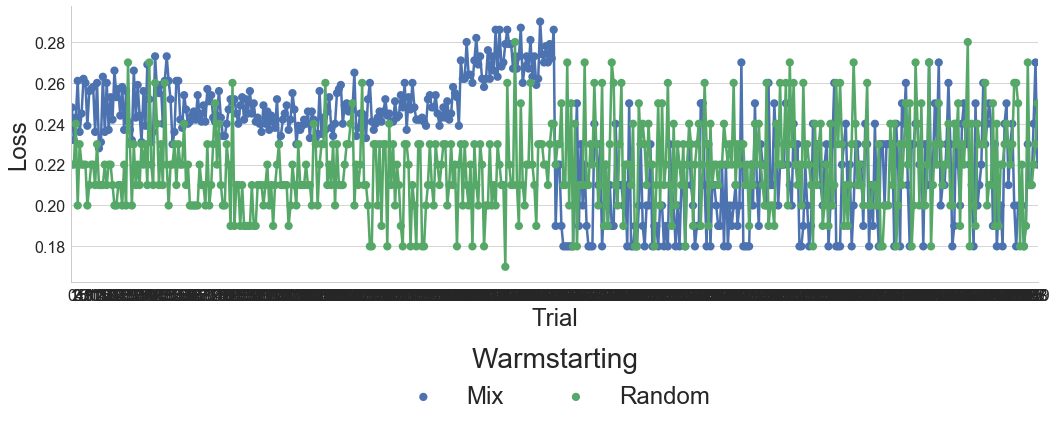

In [138]:
g = sns.factorplot(data=melted, 
                   x = 'Trial', 
                   y = 'Loss', 
                   hue = 'Method', 
                   size=5, aspect=3, legend=False)
g.set_ylabels('Loss', fontsize=24)
g.set_xlabels('Trial', fontsize=24)
#g.set(ylim=(0.189,0.25))
#g.set_ylim([0.2,0.25])
#g.set(xticks=[0,19,39,59,79,99])
#g.set(yticks=[0.20, 0.25])
#g.set_xticklabels(['1','20','40','60','80','100'], fontsize = 22)
#g.set_yticklabels(['0.20', '0.25'],fontsize = 22)
legend = plt.legend(title = 'Warmstarting',
           bbox_to_anchor=(0.5, -.2),
           loc='upper center',
           borderaxespad=0.,
           fancybox = True,
           shadow=True,
           ncol = 4, 
           fontsize = 24)
plt.setp(legend.get_title(),fontsize=28)
#plt.savefig('figures/paper/t31-f7707-adaptive-method-random.eps', format='eps', dpi=1000, bbox_inches='tight')

In [111]:
pipelines = ['7707','X1','X2','X3']
warms = np.repeat(len(set(np.where(warmLosses == np.min(warmLosses))[0])),4)
colds = np.repeat(len(set(np.where(coldLosses == 0.18999999999999995)[0])),4)
counts = pd.DataFrame({'Pipeline':pipelines,'Yes':warms,'No':colds}).melt('Pipeline', var_name='Warmstarting', value_name='Count')

NameError: name 'warmLosses' is not defined

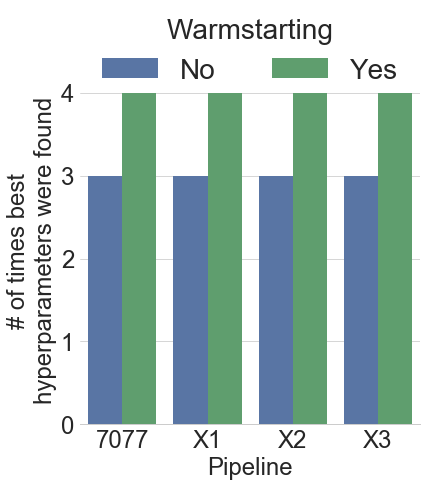

In [232]:
g = sns.factorplot(x="Pipeline", y="Count", hue="Warmstarting", data=counts,
                   size=6, kind="bar", legend= False)
g.set_ylabels('# of times best\nhyperparameters were found', fontsize = 24)
g.set_xlabels('Pipeline', fontsize=24)
g.set_xticklabels( fontsize = 24)
g.set(yticks=range(max(counts['Count'])+1))
g.set_yticklabels(range(max(counts['Count'])+1),fontsize = 24)
g.despine(left = True)
legend = g.ax.legend(title = 'Warmstarting',
           bbox_to_anchor=(0.5, 1.2),
           loc='upper center',
           borderaxespad=0.,
           fancybox = True,
           shadow=True,
           ncol = 2,
           fontsize = 28)
plt.setp(legend.get_title(),fontsize = 28)

plt.savefig('figures/task31-cold-starting-warm-besthyperparametersfound.eps', format='eps', dpi=1000, bbox_inches='tight')

## Comparison of the Accuracy for Warm and Cold Trials
In the experiment, we warm started the Trials object with 500 points from the OpenML repository and run the optimization process 100 times.
Figure above shows that using the existing experiments to warm start the Trials object for the bayesian optimization reduces the average loss of the subsequent trials (cold start = 0.256, warm start = 0.217).
Moreover, the best result (0.20) was found slightly earlier in warm start (after 17 iterations) when compared to the cold start (25 iterations).
However, running the experiments for longer trials (500) sometimes results in cold start achieving a better result. I believe, wamr starting results in local minima and forces the search to focus more on exploitation rather than exploration.
We should address the problem of local minima and propose solutions for fixing it.


## Conclusion
Warm starting for bayesian optimization certainly shows promising result. We must address some of its issues and perform more experiments on different datasets and pipelines.

## Appendix

In [ ]:
# darw the distributino of the error rate for individual parameters
def drawPlots(targetTrial):
    plt.figure(figsize=(10,10))
    plt.subplot(3,3,1)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__tol'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__tol')
    plt.subplot(3,3,2)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__gamma'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__gamma')
    plt.subplot(3,3,3)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__C'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__C')
    plt.subplot(3,3,4)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__degree'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__degree')
    plt.subplot(3,3,5)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__coef0'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__coef0')
    plt.subplot(3,1,3)
    ax = sns.regplot(np.array(range(len(targetTrial.losses()))), np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('Trials vs Quality over time')

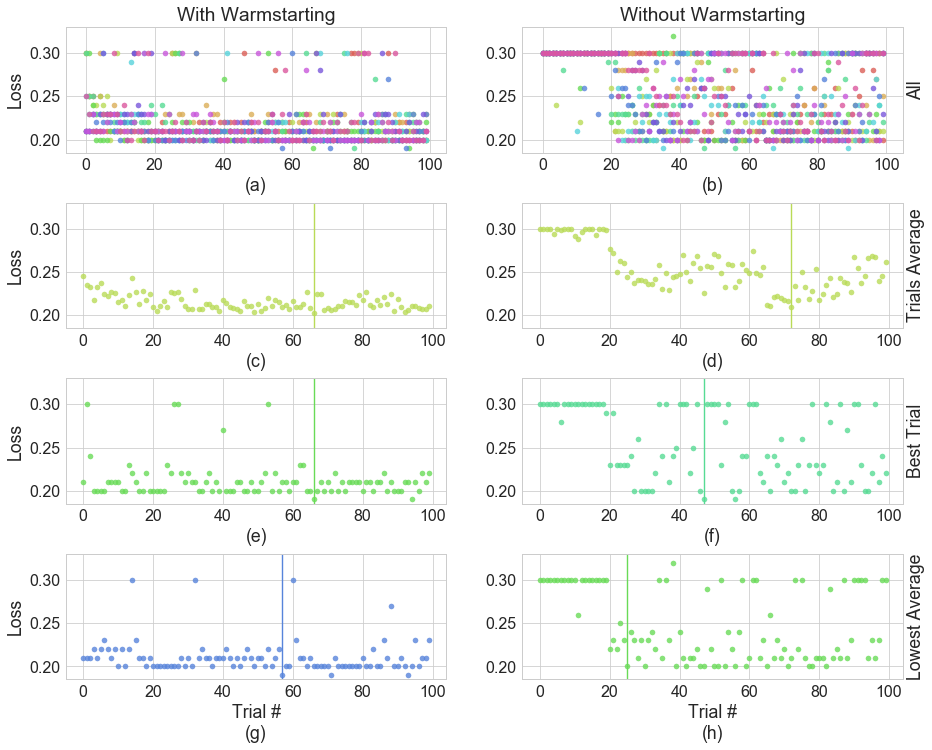

In [15]:
plt.figure(figsize=(15,12))
# ALL PLOTS
## warm
plt.subplot(4,2,1)
plt.subplots_adjust(hspace = 0.4)
for i in range(warmLosses.shape[0]):
    ax = sns.regplot(x = np.array(range(len(warmLosses[i]))), y = warmLosses[i], fit_reg=False, color=sns.color_palette("hls", 10)[i])
    ax.set_ylim(0.185,0.33)
    ax.set_ylabel('Loss')
    ax.set_title('With Warmstarting')
    ax.set_xlabel('(a)')
## cold
plt.subplot(4,2,2)
for i in range(coldLosses.shape[0]):
    ax = sns.regplot(x = np.array(range(len(coldLosses[i]))), y = coldLosses[i], fit_reg=False, color=sns.color_palette("hls", 10)[i])
    ax.set_ylim(0.185,0.33)
    ax.set_title('Without Warmstarting')
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('All')
    ax.set_xlabel('(b)')

# Average pointwise
## warm
plt.subplot(4,2,3)
warmAvg = np.average(warmLosses,axis=0)
ax = sns.regplot(x = np.array(range(len(warmAvg))), y = warmAvg, fit_reg=False, color=sns.color_palette("hls", 10)[2])
plt.vlines(ymin=0.185, ymax=0.33 , x = np.argmin(warmAvg),color=sns.color_palette("hls", 10)[2])
ax.set_ylim(0.185,0.33)
ax.set_ylabel('Loss')
ax.set_xlabel('(c)')
## cold
plt.subplot(4,2,4)
coldAvg = np.average(coldLosses,axis=0)
ax = sns.regplot(x = np.array(range(len(coldAvg))), y = coldAvg, fit_reg=False, color=sns.color_palette("hls", 10)[2])
plt.vlines(ymin=0.185, ymax=0.33 , x = np.argmin(coldAvg),color=sns.color_palette("hls", 10)[2])
ax.set_ylim(0.185,0.33)
ax.yaxis.set_label_position("right")
ax.set_ylabel('Trials Average')
ax.set_xlabel('(d)')

# Experiment with Best Value
## warm
plt.subplot(4,2,5)
bestWarmIndex = np.where(warmLosses == np.min(warmLosses))[0][0]
warmBest = warmLosses[bestWarmIndex]
ax = sns.regplot(x = np.array(range(len(warmBest))), y = warmBest, fit_reg=False, color=sns.color_palette("hls", 10)[bestWarmIndex])
plt.vlines(ymin=0.185, ymax=0.33 , x = np.argmin(warmBest),color=sns.color_palette("hls", 10)[bestWarmIndex])
ax.set_ylim(0.185,0.33)
ax.set_ylabel('Loss')
ax.set_xlabel('(e)')
## cold
plt.subplot(4,2,6)
bestColdIndex = np.where(coldLosses == np.min(coldLosses))[0][0]
coldBest = coldLosses[bestColdIndex]
ax = sns.regplot(x = np.array(range(len(coldBest))), y = coldBest, fit_reg=False, color=sns.color_palette("hls", 10)[bestColdIndex])
plt.vlines(ymin=0.185, ymax=0.33 , x = np.argmin(coldBest),color=sns.color_palette("hls", 10)[bestColdIndex])
ax.set_ylim(0.185,0.33)
ax.set_xlabel('(f)')
ax.yaxis.set_label_position("right")
ax.set_ylabel('Best Trial')

# Lowest AVG EXPR
## Warm
plt.subplot(4,2,7)
bestWarmIndex = np.argmin(np.average(warmLosses, axis=1))
warmBest = warmLosses[bestWarmIndex]
ax = sns.regplot(x = np.array(range(len(warmBest))), y = warmBest, fit_reg=False, color=sns.color_palette("hls", 10)[bestWarmIndex])
plt.vlines(ymin=0.185, ymax=0.33 , x = np.argmin(warmBest),color=sns.color_palette("hls", 10)[bestWarmIndex])
ax.set_ylim(0.185,0.33)
ax.set_xlabel('Trial #\n(g)')
ax.set_ylabel('Loss')
## cold
plt.subplot(4,2,8)
bestColdIndex = np.argmin(np.average(coldLosses, axis=1))
coldBest = coldLosses[bestColdIndex]
ax = sns.regplot(x = np.array(range(len(coldBest))), y = coldBest, fit_reg=False, color=sns.color_palette("hls", 10)[bestColdIndex])
plt.vlines(ymin=0.185, ymax=0.33 , x = np.argmin(coldBest),color=sns.color_palette("hls", 10)[bestColdIndex])
ax.set_ylim(0.185,0.33)
ax.set_xlabel('Trial #\n(h)')
ax.yaxis.set_label_position("right")
ax.set_ylabel('Lowest Average')

plt.savefig('figures/10-experiments-trials100-task31.eps', format='eps', dpi=1000, bbox_inches='tight')